# Failure cases analysis

In [1]:
import matplotlib.pyplot as plt 
import os.path as osp
from dataset.ReferDataset import ReferDataset
import torch 
import config 
from model.LVAT import LVAT
from PIL import Image
from dataset.transform import get_transform
class Config(object):
    def __init__(self):
        self.type='val'
        self.refer_data_root='./data'
        self.dataset='refcoco'
        self.splitBy='unc'
        self.size=448
        self.bert_tokenizer='bert-base-uncased'
        self.eval=True
        self.eval_mode="cat"
        self.cfg_file="configs/swin_base_patch4_window7_224.yaml"
args=Config()
dataset=ReferDataset(args,
                     split=args.type,
                     image_transforms=get_transform(args),
                     eval_mode=args.eval)
refer=dataset.refer # 可以获取原始图像信息

In [2]:
# visualization functions
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False)

torch.cuda.set_device(4)
print(f"number of GPUs:{torch.cuda.device_count()}")
print(f"current device:{torch.cuda.current_device()}")



# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def apply_mask(image,mask,color,alpha=0.5):
    """Apply the given mask to the image
    """
    for c in range(3):
        image[:,:,c]=np.where(mask==1,
                              image[:, :, c] *(1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
    return image

def plot_results(pil_img,mask):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    c=colors[0]
    np_image=apply_mask(np_image,mask,c)
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=c)
        ax.add_patch(p)
    
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

import torch.nn.functional as F
def plot_inference(emb,att_mask,img,batch_size,im): # im is PIL image
    if args.eval_mode=='cat':
        emb=emb.view(batch_size,-1)
        att_mask=att_mask.view(batch_size,-1)
        output=model(img,emb,att_mask)
    np_img=np.array(im)
    ori_H,ori_W,_=np_img.shape
    output=F.interpolate(output,size=[ori_H,ori_W],mode='bilinear')
    pred=output.argmax(1) #[1,ori_H,ori_W]
    pred=pred.cpu().numpy()
    pred=pred.squeeze(0)

    plot_results(im,pred)


number of GPUs:8
current device:4


In [3]:
# bulid model and load pretrained model
from logger import create_logger
import config
import torch.distributed as dist
import os 
cfg=config.get_config(args)
logger = create_logger(output_dir=cfg.OUTPUT, dist_rank=0, name=f"{cfg.MODEL.NAME}")
model=LVAT(cfg,logger)
model.cuda()
checkpoint=torch.load('checkpoint/ckpt_448_epoch_25.pth',map_location='cpu')
model.load_state_dict(checkpoint['model'],strict=False)
model.eval()

=> merge config from configs/swin_base_patch4_window7_224.yaml


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required 

[2021-12-28 20:19:54 LAVT_swin_base_patch4_window7_224](util.py 66): INFO ==============> Loading weight checkpoint/swin_base_patch4_window7_224_22k.pth for fine-tuning......
[2021-12-28 20:19:55 LAVT_swin_base_patch4_window7_224](util.py 147): WARNING _IncompatibleKeys(missing_keys=['Pwans.0.Wk.weight', 'Pwans.0.Wk.bias', 'Pwans.0.Wv.weight', 'Pwans.0.Wv.bias', 'Pwans.0.Wq.weight', 'Pwans.0.Wq.bias', 'Pwans.0.Wm.weight', 'Pwans.0.Wm.bias', 'Pwans.0.Ww.weight', 'Pwans.0.Ww.bias', 'Pwans.0.Wo.weight', 'Pwans.0.Wo.bias', 'Pwans.0.ins_q.weight', 'Pwans.0.ins_q.bias', 'Pwans.0.ins_w.weight', 'Pwans.0.ins_w.bias', 'Pwans.1.Wk.weight', 'Pwans.1.Wk.bias', 'Pwans.1.Wv.weight', 'Pwans.1.Wv.bias', 'Pwans.1.Wq.weight', 'Pwans.1.Wq.bias', 'Pwans.1.Wm.weight', 'Pwans.1.Wm.bias', 'Pwans.1.Ww.weight', 'Pwans.1.Ww.bias', 'Pwans.1.Wo.weight', 'Pwans.1.Wo.bias', 'Pwans.1.ins_q.weight', 'Pwans.1.ins_q.bias', 'Pwans.1.ins_w.weight', 'Pwans.1.ins_w.bias', 'Pwans.2.Wk.weight', 'Pwans.2.Wk.bias', 'Pwans.2.Wv

LVAT(
  (textEncoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


### compute prec@0.5

In [4]:
# evaluate the results
from utils.util import AverageMeter
@torch.no_grad()
def validate(args,model,dataset,threshold):
    model.eval()
    len_dataset=len(dataset)
    failure_cases_id=[]
    failure_cases_IoU=[]
    all_IoU=[]
    IoU_meter=AverageMeter()
    for index in range(len_dataset):
        # get original infomation about image
        img,target,emb,att_mask=dataset[index]
        img=img.unsqueeze(0)
        target=target.unsqueeze(0)

        img,target,emb,att_mask=img.cuda(),target.cuda(),emb.cuda(),att_mask.cuda()

        _,o_H,o_W=target.size()
        # compute output for different mode
        if args.eval_mode=='cat':
            emb=emb.view(1,-1)
            att_mask=att_mask.view(1,-1)
            output=model(img,emb,att_mask)
        # compute I and U
        output=F.interpolate(output,(o_H,o_W),align_corners=True,mode='bilinear')
        pred=output.argmax(1)
        I=torch.sum(torch.mul(pred,target))*1.0
        U=torch.sum(torch.add(pred,target))*1.0-I
        IoU=I*1.0/U # [overall IOU of batch]

        IoU_meter.update(IoU)
        all_IoU.append(IoU)
        if IoU < threshold:
            logger.info(
                f'Test: [{index}/{len_dataset}]\t'
                f'IoU {100*IoU_meter.val:.3f}\t'
                f'mIoU {100*IoU_meter.avg:.3f}\t'
            )
            failure_cases_id.append(index)
            failure_cases_IoU.append(IoU)
    logger.info(
        f'mIoU {100*IoU_meter.avg:.3f}\t'
    )

    
    return failure_cases_id,failure_cases_IoU,all_IoU

failure_cases_id,failure_cases_IoU,all_IoU=validate(args,model,dataset,0.5)

[2021-12-28 20:20:08 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [3/3811]	IoU 4.880	mIoU 68.987	
[2021-12-28 20:20:08 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [5/3811]	IoU 43.170	mIoU 63.842	
[2021-12-28 20:20:10 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [21/3811]	IoU 7.680	mIoU 74.161	
[2021-12-28 20:20:12 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [39/3811]	IoU 0.000	mIoU 75.771	
[2021-12-28 20:20:13 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [45/3811]	IoU 0.790	mIoU 75.199	
[2021-12-28 20:20:14 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [55/3811]	IoU 49.543	mIoU 75.375	
[2021-12-28 20:20:14 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [60/3811]	IoU 0.000	mIoU 74.583	
[2021-12-28 20:20:15 LAVT_swin_base_patch4_window7_224](137405729.py 35): INFO Test: [65/3811]	IoU 44.467	mIoU 74.964	
[2021-12-28 20:20:16 LAVT_swin_base_patch4_window7_224]

In [5]:
print(f"number of failure cases: {len(failure_cases_id)}")
print(f"Prec@0.5: {(1-len(failure_cases_id)*1.0/len(dataset))*100:.3f}%")

number of failure cases: 676
Prec@0.5: 82.262%


In [6]:
# we should set more threshold to see what destory our model
# for futher analysis , and avoid redundant computing , save the statistic results to file
import numpy as np 
failure_cases_id=np.array(failure_cases_id)
failure_cases_IoU=[iou.cpu().item() for iou in failure_cases_IoU]
all_IoU=[iou.cpu().item() for iou in all_IoU]
failure_cases_IoU=np.array(failure_cases_IoU)

np.savetxt('./checkpoint/id.txt',failure_cases_id,fmt='%d')
np.savetxt('./checkpoint/IoU.txt',failure_cases_IoU,fmt='%.5f')
np.savetxt('./checkpoint/all_IoU.txt',all_IoU,fmt='%.5f')



### load statistic results and analysis

/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


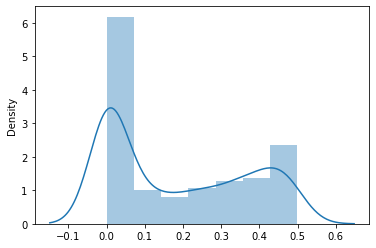

In [7]:
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
failure_cases_IoU=np.loadtxt('./checkpoint/IoU.txt',dtype=np.float32)
all_IoU=np.loadtxt('./checkpoint/all_IoU.txt',dtype=np.float32)
failure_cases_id=np.loadtxt('./checkpoint/id.txt',dtype=np.int32)

sns.distplot(failure_cases_IoU,hist=True)
plt.savefig('./checkpoint/stat.png')


/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


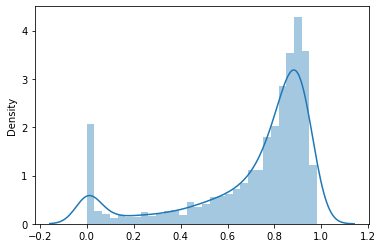

In [8]:
sns.distplot(all_IoU,hist=True)
plt.savefig('./checkpoint/all_stat.png')

目前可以看到在failure cases中,IoU的分布呈中间点，两边高的形式

In [9]:
# set more threshold to analyze
low_threshold,high_threshold=0.1,0.4
low_ids=np.where(failure_cases_IoU<low_threshold)[0]
high_ids=np.where(failure_cases_IoU>high_threshold)[0]

# IoU < 0.1 cases
low_refer_ids=failure_cases_id[low_ids]
low_ious=failure_cases_IoU[low_ids]
# IoU < 0.5 cases
high_refer_ids=failure_cases_id[high_ids]
high_ious=failure_cases_IoU[high_ids]

1. bed spread closest to photographer
2. yellow sheet bottom left
box=seg


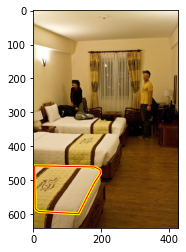

In [10]:
import random
random.seed(20)
ids=random.randint(0,len(high_refer_ids))
index_id=int(high_refer_ids[ids])
ref_id=dataset.ref_ids[index_id]
ref=refer.loadRefs(ref_id)[0]
image=refer.Imgs[refer.getImgIds(ref_id)[0]]
refer.showRef(ref)

(640, 427, 3)


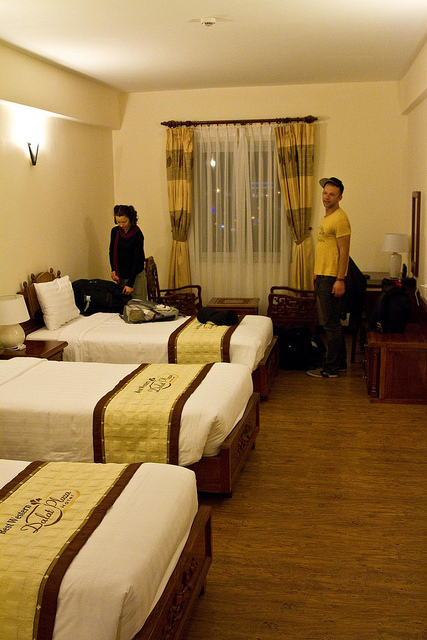

In [11]:
import os.path as osp
import numpy as np 
image_path=osp.join(refer.IMAGE_DIR,image['file_name'])
im=Image.open(image_path)
print(np.array(im).shape)
im

/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


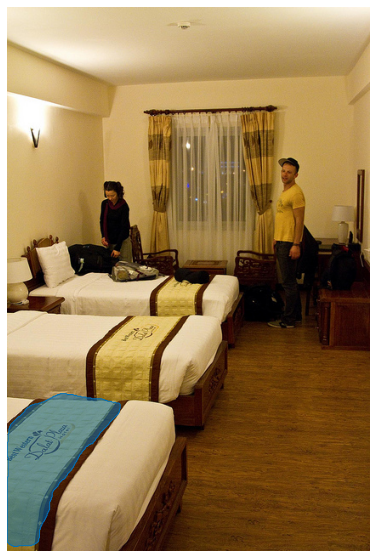

In [12]:
# plot failed eaxmples
img,_,emb,att_mask=dataset[index_id]
img=img.unsqueeze(0)
img,emb,att_mask=img.cuda(),emb.cuda(),att_mask.cuda()
plot_inference(emb,att_mask,img,1,im)


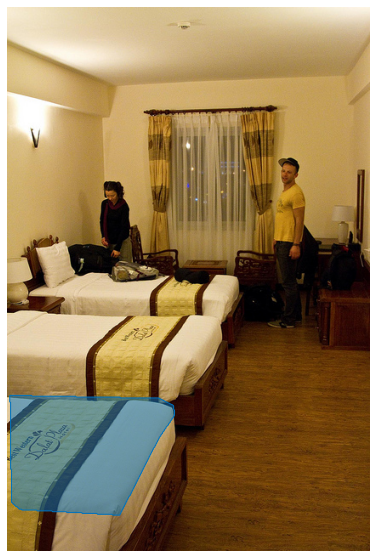

In [13]:
gt_mask=refer.getMask(ref)['mask']
plot_results(im,gt_mask)
